# Consistency between the C3S Atlas dataset and its origins: Case study

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Production date: 2025-09-30.

Dataset version: 2.0.

Produced by: Olivier Burggraaff, Nicole Reynolds (National Physical Laboratory).

## 🌍 Use case: Retrieving climate indicators from the Copernicus Interactive Climate Atlas

## ❓ Quality assessment question
* **Are the climate indicators in the dataset underpinning the Copernicus Interactive Climate Atlas consistent with their origin datasets?**
* **Can the dataset underpinning the Copernicus Interactive Climate Atlas be reproduced from its origin datasets?**

The [_Copernicus Interactive Climate Atlas_](https://atlas.climate.copernicus.eu/atlas), or _C3S Atlas_ for short, is a C3S web application providing an easy-to-access tool for exploring climate projections, reanalyses, and observational data [[Gutiérrez+24](https://doi.org/10.21957/ah52ufc369)].
Version 2.0 of the application allows the user to interact with 12 datasets:

| Type               | Dataset       |
|--------------------|---------------|
| Climate Projection | CMIP6         |
| Climate Projection | CMIP5         |
| Climate Projection | CORDEX-CORE   |
| Climate Projection | CORDEX-EUR-11 |
| Reanalysis         | ERA5          |
| Reanalysis         | ERA5-Land     |
| Reanalysis         | ORAS5         |
| Reanalysis         | CERRA         |
| Observations       | E-OBS         |
| Observations       | BERKEARTH     |
| Observations       | CPC           |
| Observations       | SST-CCI       |

These datasets are provided through an intermediary dataset, the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) or _C3S Atlas dataset_ for short [[C3S Atlas dataset](https://doi.org/10.24381/cds.h35hb680)].
Compared to their origins, the versions of the climate datasets within the C3S Atlas dataset have been processed following the workflow in Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q01_workflow-fig>`.

```{figure} attachment:c3s_atlas_dataset_workflow.png
---
height: 360px
name: multi-origin-c3s-atlas_consistency_q01_workflow-fig
---
Schematic representation of the workflow for the production of the C3S Atlas dataset from its origin datasets, from the [User-tools for the C3S Atlas](https://ecmwf-projects.github.io/c3s-atlas/chapter01.html).
```

Because a wide range of users interact with climate data through the C3S Atlas application, it is crucial that the underpinning dataset represent its origins correctly.
In other words, the C3S Atlas dataset must be consistent with and reproducible from its origins.
Here, we assess this consistency and reproducibility by comparing climate indicators retrieved from the C3S Atlas dataset with their equivalents calculated from the origin dataset, mirroring the workflow from Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q01_workflow-fig>`.
While a full analysis and reproduction of every record within the C3S Atlas dataset is outside the scope of quality assessment
(and would require high-performance computing infrastructure),
a case study with a narrower scope probes these quality attributes of the dataset
and can be a jumping-off point for further analysis by the reader.

This notebook is part of a series:
| Notebook | Contents |
|---|---|
| **Consistency between the C3S Atlas dataset and its origins: Case study** | Comparison between C3S Atlas dataset and one origin dataset (CMIP6) for one indicator (`tx35`), including detailed setup. |
| [](./derived_multi-origin-c3s-atlas_consistency_q02) | Comparison between C3S Atlas dataset and one origin dataset (CMIP6) for multiple indicators. |
| [](./derived_multi-origin-c3s-atlas_consistency_q03) | Comparison between C3S Atlas dataset and multiple origin datasets for one indicator. |
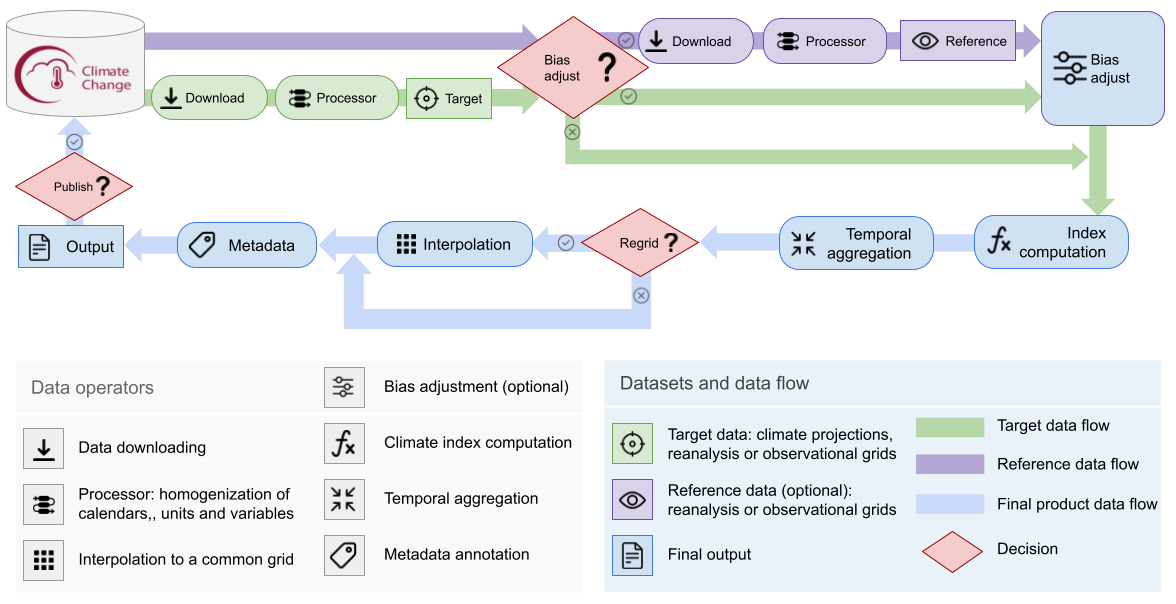

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Values of climate indicators (here `tx35`) provided by the Gridded dataset underpinning the Copernicus Interactive Climate Atlas are highly consistent with values calculated from its origin datasets (here the CMIP6 multi-model ensemble). The general distribution of indicator values is the same across time and space. However, small differences exist due to the difference in grid, especially in locations with steep gradients. Users of the C3S Atlas dataset – and thus users of the C3S Atlas application – should be aware that values retrieved from C3S Atlas may differ slightly from a manual analysis of the origin dataset.
* The C3S Atlas dataset is highly reproducible from its origins, at least for the `tx35` indicator and CMIP6 dataset. Fewer than 0.1% of pixel pairs show a non-zero difference between the C3S Atlas dataset and its reproduction, and in those cases the differences tend to be small. The origins of the differences are unclear, possibly simply the result of changes in underlying data or software. From a user perspective, it is safe to say that the C3S Atlas dataset, and the C3S Atlas application with it, is traceable and reproducible.
```

## 📋 Methodology
This quality assessment tests the consistency between climate indicators retrieved from the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) [[C3S Atlas dataset](https://doi.org/10.24381/cds.h35hb680)] and their equivalents calculated from the origin datasets,
as well as the reproducibility of said dataset.

This notebook starts the quality assessment with a simple case study: one climate indicator derived from one origin dataset.
This indicator is `tx35`,
the _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_,
derived from the CMIP6 multi-model ensemble [[CMIP6 dataset](https://doi.org/10.24381/cds.c866074c)].
This notebook mirrors [one of the reproducibility demonstrations](https://ecmwf-projects.github.io/c3s-atlas/notebooks/tx35.html) written by the data provider.

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-codesetup)**
 * Install User-tools for the C3S Atlas.
 * Import all required libraries.
 * Definition of helper functions.

**[](section-origin)**
 * Download data from the origin dataset.
 * Homogenise data.
 * Calculate indicator.
 * Interpolate to a common and regular grid.

**[](section-c3s-atlas)**
 * Download data from the C3S Atlas dataset.

**[](section-results)**
 * Consistency: Compare the C3S Atlas and reproduced datasets on native grids.
 * Reproducibility: Compare the C3S Atlas and reproduced datasets on the C3S Atlas grid.

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for
downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data))
and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data.
Because earthkit is in active development, some functionality may change after this notebook is published.
If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Install the User-tools for the C3S Atlas
This notebook uses the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas), which can be installed from GitHub using `pip`.
For convenience, the following cell can do this from within the notebook.
Further details and alternative options for installing this library are available in its [documentation](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements).

In [ ]:
!pip install git+https://github.com/ecmwf-projects/c3s-atlas.git

#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [2]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd
import warnings

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial
from dask.array.core import PerformanceWarning
warnings.simplefilter(action="ignore", category=PerformanceWarning)

# Data pre-processing
from c3s_atlas.fixers import apply_fixers
import c3s_atlas.interpolation as xesmfCICA

# Climate indicators
import xclim

# Visualisation
import earthkit.plots as ekp
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

# Type hints
from typing import Iterable, Optional
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

#### Define indicators
This section defines functions and variables for calculating and using the climate indicators:

In [3]:
# Functions to calculate indicators
def cal_tx35(ds: xr.Dataset) -> xr.Dataset:
    """ Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C """
    ds_tx35 = xclim.indices.tx_days_above(ds["tasmax"], thresh="35.0 degC", freq="MS", op=">").to_dataset(name="tx35")
    return ds_tx35

The following cell defines [earthkit-plots styles](https://earthkit-plots.readthedocs.io/en/latest/_api/plots/styles/index.html) for the indicators.
These styles define the colour maps and colour bar ranges for each quantity.
Earthkit-plots styles are explained further in the [corresponding documentation](https://earthkit-plots.readthedocs.io/en/latest/examples/examples/examples.html#Styles).

In [4]:
# Styles for indicators
n_diff = 5  # Levels in difference charts
_style_monthly_days      = {"vmin": 0,     "vmax": 30,    "extend": "neither"}
_style_monthly_days_diff = {"vmin": -2.5,  "vmax": 2.5,   "extend": "both"}
_style_tx35      = _style_monthly_days      | {"cmap": plt.cm.Oranges.resampled(10)}
_style_tx35_diff = _style_monthly_days_diff | {"cmap": plt.cm.RdBu_r.resampled(n_diff)}

styles = {
    "tx35":      ekp.styles.Style(**_style_tx35),
    "tx35_diff": ekp.styles.Style(**_style_tx35_diff),
}

# Apply general settings
for style in styles.values():
    style.normalize = False

#### Helper functions
This section defines some functions and variables used in the following analysis, allowing code cells in later sections to be shorter and ensuring consistency.

##### Data (pre-)processing

The following functions handle the homogenisation of origin data to a consistent format using the [User-tools for the C3S Atlas](https://ecmwf-projects.github.io/c3s-atlas/intro.html):

In [6]:
# Homogenisation of origin dataset
def homogenise(ds: xr.Dataset, var_name: str, project_id: str) -> xr.Dataset:
    """ Homogenise a dataset `ds` for one variable `var_name` """
    var_mapping = {
                "dataset_variable": {var_name: "data"},
                "aggregation": {"data": "mean"},
        }
    data = apply_fixers(ds, var_name, project_id, var_mapping)
    return data

# Homogenisation of origin dataset, multiple non-consecutive years
def homogenise_multiple_years(ds: xr.Dataset, var_name: str, project_id: str) -> xr.Dataset:
    """ Homogenise a dataset `ds` for one variable `var_name`, grouping over multiple years """
    homogenise_here = partial(homogenise, var_name=var_name, project_id=project_id)
    data = ds.groupby("time.year").map(homogenise_here)
    return data

The following functions handle regridding and interpolating data based on ESMF as implemented in the [User-tools for the C3S Atlas](https://ecmwf-projects.github.io/c3s-atlas/intro.html).
This step is explained in more detail in the relevant section below.

In [7]:
# Interpolation from native grid to C3S Atlas grid
def interpolate(ds: xr.Dataset, var_name: str) -> xr.Dataset:
    """ Interpolate a dataset `ds` to the C3S Atlas grid for one variable `var_name` """
    int_attr = {"interpolation_method": "conservative_normed",
                "lats": np.arange(-89.5, 90.5, 1),
                "lons": np.arange(-179.5, 180.5, 1),
                "var_name": var_name,
    }
    INTER = xesmfCICA.Interpolator(int_attr)
    ds_interp = INTER(ds)
    return ds_interp

The following functions aid in sub-selecting data, e.g. selecting one model from the ensemble included in the C3S Atlas dataset or selecting data for a specific time frame:

In [8]:
# C3S Atlas dataset: Individual model selection
def select_model_from_c3s_atlas_dataset(data: xr.Dataset, model: str) -> xr.Dataset:
    """ Select only data for the given model. """
    # Ensure the model ID is provided in the right format
    model_id = model.replace("_", "-")

    # Find the corresponding model ID in the list of models
    # This cannot use .sel because the coordinate is not indexed
    select_member = [str(mem) for mem in data.member_id.values if model_id in mem.lower()][0]

    # Find the corresponding data and return those
    member_ind = np.where(data.member_id == select_member)[0]
    data_member = data.sel(member=member_ind).squeeze("member")

    return data_member

# Select (multiple) years in a dataset
def select_years_in_dataset(data: xr.Dataset, years: list[int]) -> xr.Dataset:
    """ Select only data for the given year(s). """
    years_int = [int(y) for y in years]
    return data.sel(time=data.time.dt.year.isin(years_int))

# Select one month in multiple datasets
def select_month_in_multiple_datasets(*data: xr.Dataset, month: int) -> list[xr.Dataset]:
    """ Select only data for the given month, in any year. """
    data_month = [d.groupby("time.month")[month] for d in data]
    return data_month

##### Statistics
The following functions calculate the difference (absolute / relative) between datasets, handling metadata etc.:

In [9]:
# Constants
NONZERO_THRESHOLD = 1e-5

# Difference between datasets
def difference_between_datasets(data1: xr.Dataset, data2: xr.Dataset, diff_variables: Iterable[str]) -> xr.Dataset:
    """ Calculate the difference between two datasets, preserving CRS and metadata. """
    # Subtract
    data1, data2 = [d.drop_vars(["lat_bnds", "lon_bnds", "time_bnds", "height"], errors="ignore") for d in (data1, data2)]
    difference = xr.ufuncs.subtract(data1, data2)
    return difference

def relative_difference_between_datasets(data1: xr.Dataset, data2: xr.Dataset, reldiff_variables: Iterable[str]) -> xr.Dataset:
    """
    Calculate the relative [%] difference between two datasets, preserving CRS and updating metadata.
    Relative difference is calculated relative to the first dataset.
    Where data1 == 0 and data2 == 0, the relative difference is set to 0 too.
    """
    # Select and calculate
    data1, data2 = [dataset.drop_vars([var for var in dataset.data_vars if var not in [*reldiff_variables, "crs"]]) \
                        for dataset in (data1, data2)]

    relative_difference = (data1 - data2) / data1 * 100.

    # Replace 0/0 with 0
    data1_zero = (data1 <= NONZERO_THRESHOLD)  # Threshold slightly > 0 because of floating-point errors
    relative_difference = relative_difference.where(~data1_zero, 0.)

    # Add name
    relative_difference = relative_difference.assign_attrs({"name": "C3S Atlas – Reproduced [%]"})

    return relative_difference

def fraction_over_threshold(data: pd.DataFrame, threshold: float=NONZERO_THRESHOLD) -> pd.DataFrame:
    """ Calculate the % of non-NaN cells in a dataframe greater than a given threshold. """
    data_over = (data >= threshold)
    frac_over = data_over.sum() / data_over.count() * 100.
    return frac_over

The following functions calculate and display metrics for the difference between two datasets, e.g. mean and median deviation:

In [10]:
def comparison_statistics(dataset1: xr.Dataset, dataset2: xr.Dataset, indicator: str) -> pd.DataFrame:
    """
    Given two datasets, calculate a number of statistics for each variable and return the result in a table.
    `threshold` is used to determine values close to 0 (to within a float error).
    This version is hardcoded for one indicator in multiple years.
    """
    # Calculate differences
    differences     =          difference_between_datasets(dataset1, dataset2, diff_variables=[indicator])
    differences_rel = relative_difference_between_datasets(dataset1, dataset2, reldiff_variables=[indicator])

    # Convert to pandas
    differences = differences.to_dataframe()[[indicator]]
    differences_abs = differences.abs()

    differences_rel = differences_rel.to_dataframe()[[indicator]]
    differences_rel_abs = differences_rel.abs()

    # In this notebook: Group by year first
    differences, differences_abs, differences_rel, differences_rel_abs = [
        d.groupby(differences.index.get_level_values("time").year) for d in
        (differences, differences_abs, differences_rel, differences_rel_abs)
    ]

    # Calculate aggregate statistics
    md   =         differences.agg(["mean", "median"])  \
                              .rename(columns={"median": r"Median Δ", "mean": "Mean Δ"})
    mad  =     differences_abs.agg(["median"])  \
                              .rename(columns={"median": r"Median |Δ|"})
    mapd = differences_rel_abs.agg(["median"])  \
                              .rename(columns={"median": r"Median |Δ| [%]"})
    nonzero =  differences_abs.apply(fraction_over_threshold)  \
                              .rename(columns={indicator: r"% where |Δ| ≥ ε"})
    md, mad, mapd = [df.droplevel(0, axis=1) for df in (md, mad, mapd)]

    # Calculate correlation coefficients
    nr_years, data1_years, data2_years = _group_multiple_datasets_by_years(dataset1, dataset2)
    corrs = {year: xr.corr(d1[indicator], d2[indicator]).values
             for year, d1, d2 in _loop_over_data_grouped_by_year(data1_years, data2_years)}
    corrs = pd.DataFrame.from_dict(corrs, orient="index", columns=["Pearson r"])

    # Combine statistics into one dataframe
    stats = pd.concat([md, mad, nonzero, mapd, corrs], axis=1)

    return stats

def display_difference_stats(dataset1: xr.Dataset, dataset2: xr.Dataset, *args, **kwargs) -> str:
    """ Given two datasets, calculate a number of statistics for each variable and display the result in a table. """
    comparison_stats = comparison_statistics(dataset1, dataset2, *args, **kwargs)
    formatted = comparison_stats.style \
                                .format(precision=5)  \
                                .set_caption("C3S Atlas – Reproduced")
    return formatted

##### Visualisation
The following cells contain functions for plotting results, starting with some base helper functions (e.g. displaying in Jupyter Notebook or Jupyter Book style, adding textboxes with consistent formatting, etc.):

In [11]:
# Visualisation: Helper functions, general
def _glue_or_show(fig: plt.Figure, glue_label: Optional[str]=None) -> None:
    """
    If `glue` is available, glue the figure using the provided label.
    If not, display the figure in the notebook.
    """
    try:
        glue(glue_label, fig, display=False)
    except TypeError:
        plt.show()
    finally:
        plt.close()

def _add_textbox_to_subplots(text: str, *axs: Iterable[plt.Axes | ekp.Subplot], right=False) -> None:
    """ Add a text box to each of the specified subplots. """
    # Get the plt.Axes for each ekp.Subplot
    axs = [subplot.ax if isinstance(subplot, ekp.Subplot) else subplot for subplot in axs]

    # Set up location
    x = 0.95 if right else 0.05
    horizontalalignment = "right" if right else "left"

    # Add the text
    for ax in axs:
        ax.text(x, 0.95, text, transform=ax.transAxes,
        horizontalalignment=horizontalalignment, verticalalignment="top",
        bbox={"facecolor": "white", "edgecolor": "black", "boxstyle": "round",
              "alpha": 1})

def _sharexy(axs: np.ndarray) -> None:
    """ Force all of the axes in axs to share x and y with the first element. """
    main_ax = axs.ravel()[0]
    for ax in axs.ravel():
        ax.sharex(main_ax)
        ax.sharey(main_ax)

def _symmetric_xlim(ax: plt.Axes) -> None:
    """ Adjust the xlims for one Axes to be symmetric, based on existing values. """
    current = ax.get_xlim()
    current = np.abs(current)
    maxlim = np.max(current)
    newlim = (-maxlim, maxlim)

    ax.set_xlim(newlim)

The following functions are also base helper functions, but specific to geospatial plots:

In [12]:
# Visualisation: Helper functions for geospatial plots
def _spatial_plot_append_subplots(fig: ekp.Figure, *data: xr.Dataset, domain: Optional[AnyDomain]=None, **kwargs) -> list[ekp.Subplot]:
    """ Plot any number of datasets into new subplots in an existing earthkit figure. """
    # Create subplots
    subplots = [fig.add_map(domain=domain) for d in data]

    # Plot
    for subplot, d in zip(subplots, data):
        subplot.grid_cells(d, **kwargs)

    return subplots

def _group_multiple_datasets_by_years(*data: xr.Dataset) -> tuple[int, xr.core.groupby.GroupBy]:
    """ Apply groupby("time.year") to multiple datasets, return these, and return the number of years. """
    data_by_year = [d.groupby("time.year") for d in data]
    nr_years = len(data_by_year[0])
    return nr_years, *data_by_year

def _loop_over_data_grouped_by_year(data1: xr.core.groupby.GroupBy, data2: xr.core.groupby.GroupBy):
    """ Generator to more easily loop over multiple datasets that have been grouped by year. """
    for (year, d1), (_, d2) in zip(data1, data2):
        # Remove redundant time coordinate
        d1, d2 = [d.drop_vars("time") for d in (d1, d2)]

        yield (year, d1, d2)

The following cell contains functions for geospatial comparisons between datasets on their native grids or on a common grid (the latter also showing the per-pixel difference):

In [13]:
# Visualisation: Plot indicators geospatially
def geospatial_comparison(data1: xr.Dataset, data2: xr.Dataset, indicator: str, month: int, *,
                          label1: str="C3S Atlas dataset", label2: str="Reproduced from origin",
                          domain: Optional[AnyDomain]=None,
                          glue_label: Optional[str]=None) -> ekp.Figure:
    """
    Plot one indicator in two datasets.
    If multiple years are present, loops over those using groupby.
    A specific month has to be specified.
    """
    # Pre-process: Select data in one month, group by year
    data_by_month = select_month_in_multiple_datasets(data1, data2, month=month)
    nr_years, data1_years, data2_years = _group_multiple_datasets_by_years(*data_by_month)

    # Create figure
    fig = ekp.Figure(rows=nr_years, columns=2, size=(8, 4*nr_years))

    # Plot indicators
    for year, d1, d2 in _loop_over_data_grouped_by_year(data1_years, data2_years):
        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, d1, d2, domain=domain, z=indicator, style=styles[indicator])

        # Decorate: Text + Colour bar
        _add_textbox_to_subplots(year, *subplots_data)
        subplots_data[-1].legend(label=indicator, location="right")

    # Titles on top
    titles = [label1, label2]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])

    # Show result
    _glue_or_show(fig.fig, glue_label)


# Visualisation: Plot indicator + difference geospatially
def geospatial_comparison_with_difference(data1: xr.Dataset, data2: xr.Dataset, indicator: str, month: int, *,
                                          label1: str="C3S Atlas dataset", label2: str="Reproduced from origin",
                                          domain: Optional[AnyDomain]=None,
                                          glue_label: Optional[str]=None) -> ekp.Figure:
    """
    Plot one indicator in two datasets, including the difference between them.
    If multiple years are present, loops over those using groupby.
    A specific month has to be specified.
        TO DO: glue
    """
    # Pre-process: Select data in one month, group by year
    data_by_month = select_month_in_multiple_datasets(data1, data2, month=month)
    nr_years, data1_years, data2_years = _group_multiple_datasets_by_years(*data_by_month)

    # Create figure
    fig = ekp.Figure(rows=nr_years, columns=3, size=(8, 3*nr_years))

    # Plot indicators
    for year, d1, d2 in _loop_over_data_grouped_by_year(data1_years, data2_years):
        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, d1, d2, domain=domain, z=indicator, style=styles[indicator])

        # Plot difference
        difference = difference_between_datasets(d1, d2, diff_variables=[indicator])
        subplot_diff = fig.add_map(domain=domain)
        subplot_diff.grid_cells(difference, z=indicator, style=styles[f"{indicator}_diff"])

        # Show year
        _add_textbox_to_subplots(year, *subplots_data, subplot_diff)

    # Colour bar at the bottom
    for subplot in subplots_data:
        subplot.legend(label=indicator, location="bottom")
    subplot_diff.legend(label="Difference", location="bottom")

    # Titles on top
    titles = [label1, label2, "Difference"]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])

    # Show result
    _glue_or_show(fig.fig, glue_label)

The following cell contains functions for histogram comparisons between datasets on their native grids or on a common grid (the latter also showing the per-pixel difference):

In [15]:
# Visualisation: Plot data in histograms
def histogram_comparison_by_year(data1: xr.Dataset, data2: xr.Dataset, indicator: str, *,
                                 label1: str="C3S Atlas dataset", label2: str="Reproduced from origin",
                                 glue_label: Optional[str]=None) -> plt.Figure:
    """
    Create a histogram for one indicator in two datasets, for multiple years.
    Flattens all data in the datasets, including spatial and temporal dimensions.
        TO DO: glue
    """
    # Group data by year
    nr_years, data1_years, data2_years = _group_multiple_datasets_by_years(data1, data2)

    # Create figure
    fig, axs = plt.subplots(nrows=nr_years, ncols=2, sharex=True, sharey=True,
                            figsize=(5, 2*nr_years), layout="constrained", squeeze=False)

    # Plot histograms of data
    # Loop over rows / indicators
    for ax_row, (year, d1, d2) in zip(axs, _loop_over_data_grouped_by_year(data1_years, data2_years)):
        # Loop over columns / data
        for ax, data in zip(ax_row, (d1, d2)):
            # Flatten data
            d = data[indicator].values.ravel()

            # Create histogram
            ax.hist(d, bins=31, density=True, log=True, color="black")

            # Labels
            ax.grid(True, axis="both")
            ax.set_xlabel(indicator)

        ax_row[0].set_ylabel("Frequency")

        # Identify panel
        _add_textbox_to_subplots(year, *ax_row, right=True)

    # Titles on top
    titles = [label1, label2]
    for title, ax in zip(titles, axs[0]):
        ax.set_title(title)

    # Show result
    _glue_or_show(fig, glue_label)


# Visualisation: Plot data + difference in histograms
def histogram_comparison_by_year_with_difference(data1: xr.Dataset, data2: xr.Dataset, indicator: str, *,
                                                 label1: str="C3S Atlas dataset", label2: str="Reproduced from origin",
                                                 glue_label: Optional[str]=None) -> plt.Figure:
    """
    Create a histogram for one indicator in two datasets, for multiple years, including the point-by-point difference.
    Flattens all data in the datasets, including spatial and temporal dimensions.
        TO DO: glue
    """
    # Group data by year
    nr_years, data1_years, data2_years = _group_multiple_datasets_by_years(data1, data2)

    # Create figure
    fig, axs = plt.subplots(nrows=nr_years, ncols=3,
                            figsize=(8, 2*nr_years), layout="constrained", squeeze=False)

    # Setup x/y share -- cannot be done in plt.subplots because of difference panel not sharing these
    _sharexy(axs[:, :-1])
    _sharexy(axs[:, -1])

    for ax in axs[:-1].ravel():
        ax.tick_params(axis="x", labelbottom=False)
        ax.xaxis.label.set_visible(False)

    for ax in axs[:, 1:-1].ravel():
        ax.tick_params(axis="y", labelleft=False)

    for ax in axs[:, -1].ravel():
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis="y", labelleft=False, labelright=True)

    # Plot histograms of data
    # Loop over rows / indicators
    for ax_row, (year, d1, d2) in zip(axs, _loop_over_data_grouped_by_year(data1_years, data2_years)):
        # Calculate difference
        difference = difference_between_datasets(d1, d2, diff_variables=[indicator])

        # Loop over columns / data
        for ax, data in zip(ax_row, (d1, d2)):
            # Flatten data
            d = data[indicator].values.ravel()

            # Create histogram
            ax.hist(d, bins=31, density=True, log=True, color="black")

            # Labels
            ax.grid(True, axis="both")
            ax.set_xlabel(indicator)

            # Plot difference
            difference_here = difference[indicator].values.ravel()
            ax_row[-1].hist(difference_here, bins=31, density=True, log=True, color="black")

        ax_row[0].set_ylabel("Frequency")

        # Identify panel
        _add_textbox_to_subplots(year, *ax_row, right=True)

    for ax in axs[:, -1]:  # Symmetric xlims for difference
        _symmetric_xlim(ax)

    # Titles on top
    titles = [label1, label2, "Difference"]
    for title, ax in zip(titles, axs[0]):
        ax.set_title(title)

    # Decorate figure
    axs[-1, -1].set_xlabel("Difference")

    # Show result
    _glue_or_show(fig, glue_label)

(section-origin)=
### 2. Calculate indicator from the origin dataset

#### Download data
This assessment examines the dataset in two years (2060 and 2080),
for one ensemble member
and
for one climate scenario
– which is not how climate projection data are normally used.
Good practice in climate science is to look at multi-year statistics and trends,
across multiple ensemble members.
However, since the purpose of this assessment is to assess the consistency and reproducibility of the post-processing performed to produce the C3S Atlas dataset,
it is valid to use a subset of the data here.
The specific subset used can be easily tweaked by changing the `EXPERIMENT`, `MODEL`, and `YEARS` variables in this section.

This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.
If you prefer not to use earthkit, the following requests can also be used with the [cdsapi module](https://cds.climate.copernicus.eu/how-to-api#linux-use-client-step).
In either case (earthkit-data or cdsapi), it is required to set up a CDS account and API key as explained [on the CDS website](https://cds.climate.copernicus.eu/how-to-api).

The first step is to define the parameters that will be shared between the download of the origin dataset (here CMIP6) and the C3S Atlas dataset (in the [next section](section-c3s-atlas)), namely the experiment and model member.
Next, the request to download the corresponding data from CMIP6 is defined,
in this notebook choosing only the variable necessary to calculate the `tx35` indicator, namely `daily_maximum_near_surface_air_temperature`.
Because the indicator will be calculated for multiple years, the `year` parameter of the request is left out for now.

In [17]:
indicator = "tx35"

# Define request
ORIGIN_ID = "projections-cmip6"
ORIGIN = "cmip6"  # Used in C3S Atlas download; defined here to improve customisability
EXPERIMENT = "ssp5_8_5"
MODEL = "cmcc_esm2"

request_cmip6 = {
    "experiment": EXPERIMENT,
    "model": MODEL,
    "variable": "daily_maximum_near_surface_air_temperature",
    "temporal_resolution": "daily",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "day": [f"{day:02d}" for day in range(1, 32)],
    "format": "netcdf",
}

This case study examines
two years, namely 2060 and 2080, so there are two
corresponding requests.
This can easily be changed or extended to use different years.
Separate requests are defined for each year,
rather than one combined request,
to limit the size per request.

In [18]:
YEARS = [2060, 2080]
requests_year = [{"year": str(year)} for year in YEARS]

In [ ]:
requests_cmip6_combined = [request_cmip6 | req_year for req_year in requests_year]

# Download data
ds_cmip6 = ekd.from_source("cds", ORIGIN_ID, *requests_cmip6_combined)

Earthkit downloads the data as a field list.
This is converted into an `xarray` dataset, which can be used in the following analysis.

In [20]:
data_cmip6 = ds_cmip6.to_xarray(compat="equals", data_vars="all")
data_cmip6

<xarray.Dataset> Size: 167MB
Dimensions:    (time: 730, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 6kB 2060-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 12kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 2MB dask.array<chunksize=(365, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 3MB dask.array<chunksize=(365, 288, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 161MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/a1513d6f-5325-4b99-bbe6-9b096557b100

#### Homogenise data
One of the steps in the C3S Atlas dataset production chain is homogenisation, i.e. ensuring consistency between data from different origin datasets.
This homogenisation is implemented in the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas), specifically the `c3s_atlas.fixers.apply_fixers` function.
The following changes are applied:

- The names of the spatial coordinates are standardised to `[lon, lat]`.
- Longitude is converted from `[0...360]` to `[-180...180]` format.
- The time coordinate is standardised to the CF standard calendar.
- Variable units are standardised (e.g. °C for temperature).
- Variables are resampled / aggregated to the required temporal resolution.

The homogenisation is applied in the following code cell.
The `apply_fixers` function describes the different homogenisation steps as it applies them;
this can be read by expanding the following cell outputs.

In [21]:
VARIABLE = "tasmax"
data_cmip6_homogenised = homogenise_multiple_years(data_cmip6, var_name=VARIABLE, project_id=ORIGIN)

2025-09-30 20:57:27,598 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-09-30 20:57:27,609 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 84MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2060-01-01 12:00:00 ... 2060-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 1MB dask.array<chunksize=(365, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 2MB dask.array<chunksize=(365, 288, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 81MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: 

In [22]:
data_cmip6_homogenised

<xarray.Dataset> Size: 162MB
Dimensions:  (time: 732, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB -178.8 -177.5 -176.2 -175.0 ... 177.5 178.8 180.0
  * time     (time) datetime64[ns] 6kB 2060-01-01 2060-01-02 ... 2080-12-31
    height   float64 8B 2.0
Data variables:
    tasmax   (time, lat, lon) float32 162MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/a1513d6f-5325-4b99-bbe6-9b096557b100

#### Calculate indicator
The climate indicator,
in this notebook only `tx35`,
is calculated using [xclim](https://xclim.readthedocs.io/en/stable/).
The function `cal_tx35`, defined [above](section-codesetup), performs the calculation.
This function needs to be applied year-by-year, which is achieved using `groupby`.

In [23]:
indicators_cmip6 = data_cmip6_homogenised.groupby("time.year").map(cal_tx35)
indicators_cmip6

<xarray.Dataset> Size: 11MB
Dimensions:  (time: 24, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB -178.8 -177.5 -176.2 -175.0 ... 177.5 178.8 180.0
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 192B 2060-01-01 2060-02-01 ... 2080-12-01
Data variables:
    tx35     (time, lat, lon) int64 11MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>

#### Interpolate to a common and regular grid
```{note}
This notebook uses [xESMF](https://github.com/pangeo-data/xESMF) for regridding data.
xESMF is most easily installed using mamba/conda as explained in its documentation.
Users who cannot or do not wish to use mamba/conda can manually compile and install [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/node10.html) on their machines.
In future, this notebook will use [earthkit-regrid](https://github.com/ecmwf/earthkit-regrid) instead, once it reaches suitable maturity.
```

The final step in the processing is regridding and interpolation to a standard grid (Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q01_workflow-fig>`).
This is performed through a custom function in the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas),
specifically `c3s_atlas.interpolation`.
This function is based on ESMF, as noted above.

Note that the C3S Atlas workflow calculates indicators first, then regrids.
For operations that involve averaging, like smoothing and regridding, the order of operations can affect the result, especially in areas with steep gradients [[Burggraaff+20](https://doi.org/10.1364/OE.391470)].
Examples of such areas for a temperature index are coastlines and mountain ranges.
In the case of C3S Atlas, this order of operations was a conscious choice to preserve the "raw" signals,
e.g. preventing extreme temperatures from being smoothed out.
However, it can affect the indicator values and therefore must be considered when using the C3S Atlas application or dataset.

In [ ]:
# Apply interpolation function
indicators_cmip6_interpolated = interpolate(indicators_cmip6, indicator)

In [25]:
indicators_cmip6_interpolated

<xarray.Dataset> Size: 12MB
Dimensions:   (lon: 360, lat: 180, time: 24, bnds: 2)
Coordinates:
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) datetime64[ns] 192B 2060-01-01 2060-02-01 ... 2080-12-01
Dimensions without coordinates: bnds
Data variables:
    tx35      (time, lat, lon) int64 12MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 6kB -180.0 -179.0 -179.0 ... 179.0 179.0 180.0
    lat_bnds  (lat, bnds) float64 3kB -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    crs       int64 8B 0
    height    float64 8B 2.0

(section-c3s-atlas)=
### 3. Retrieve indicator from the C3S Atlas dataset
Here, we download the same indicator as above directly from the [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://doi.org/10.24381/cds.h35hb680) so the values can be compared.

In [ ]:
# Define request
C3S_ATLAS_ID = "multi-origin-c3s-atlas"
request_c3s_atlas = {
    "origin": ORIGIN,
    "experiment": EXPERIMENT,
    "period": YEARS,
    "variable": "monthly_extreme_hot_days",
    "bias_adjustment": "no_bias_adjustment"
}

# Download data
ds_c3s_atlas = ekd.from_source("cds", C3S_ATLAS_ID, request_c3s_atlas)
data_c3s_atlas = ds_c3s_atlas.to_xarray()

The C3S Atlas dataset provides all years and members at the same time, so for convenience we pull out only the relevant entries:

In [27]:
data_member = select_model_from_c3s_atlas_dataset(data_c3s_atlas, MODEL)
data_member_years = select_years_in_dataset(data_member, YEARS)

indicators_c3s_atlas = data_member_years
indicators_c3s_atlas

<xarray.Dataset> Size: 6MB
Dimensions:          (lat: 180, bnds: 2, lon: 360, time: 24)
Coordinates:
  * lat              (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) datetime64[ns] 192B 2060-01-01 ... 2080-12-01
    member_id        <U45 180B dask.array<chunksize=(), meta=np.ndarray>
    gcm_institution  <U19 76B dask.array<chunksize=(), meta=np.ndarray>
    gcm_model        <U16 64B dask.array<chunksize=(), meta=np.ndarray>
    gcm_variant      <U8 32B dask.array<chunksize=(), meta=np.ndarray>
    threshold35c     float64 8B ...
    height2m         float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds         (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds         (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    time_bnds        (time, bnds) datetime64[ns] 384B dask.array<chunksize=(24, 2), meta=np.ndarray>
    tx35             (time, lat, lon) float32 6MB dask.array<chunksize=(24, 26, 52), meta=np.ndarray>
    crs              int32 4B ...
Attributes: (12/26)
    Conventions:                CF-1.9 ACDD-1.3
    title:                      Copernicus Interactive Climate Atlas: gridded...
    summary:                    Monthly/annual gridded data from observations...
    institution:                Copernicus Climate Change Service (C3S)
    producers:                  Institute of Physics of Cantabria (IFCA, CSIC...
    license:                    CC-BY 4.0, https://creativecommons.org/licens...
    ...                         ...
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lon_resolution:  1.0
    geospatial_lon_units:       degrees_east
    date_created:               2024-12-05 16:37:49.749769+01:00
    tracking_id:                1a7a60e7-7787-48b5-b18f-a7bf7b4de4be

(section-results)=
### 4. Results
This section contains the comparison between the indicator values retrieved from the C3S Atlas dataset vs those reproduced from the origin dataset.

The datasets are first compared on their native grids.
This means a point-by-point comparison is not possible
(because the points are not equivalent),
but the distributions can be compared geospatially and overall.
This comparison probes the consistency quality attribute:
Are the climate indicators in the dataset underpinning the Copernicus Interactive Climate Atlas consistent with their origin datasets?

The second comparison uses the regridded version of the indicators derived from the origin dataset.
This makes a point-by-point comparison possible.
This second comparison probes how well the dataset underpinning the Copernicus Interactive Climate Atlas can be reproduced from its origin datasets,
based on the workflow (Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q01_workflow-fig>`).

#### Consistency: Comparison on native grids

For the geospatial comparison,
we display the values of the indicator for one month,
across one region and globally.
For the example of `tx35`,
June
should provide many warm days in the Northern hemisphere with significant spatial variation.

In the first example, we display the results across
Europe.
This region can easily be modified in the following code cell using the [domains provided by earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/05-domains.html).
Some examples are provided in the cell (commented out using `#`).

In [28]:
# Setup: Choose a month to display
month = 6

# Setup: Pick domain using earthkit-plots
domain = "Europe"

# Other examples -- uncomment where desired
# domain = ekp.geo.domains.union(["Portugal", "Spain"], name="Iberia")
# domain = "Italy"
# domain = "South America"

It is clear from
Figures {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-regional>` and {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-global>`
that the C3S Atlas dataset and its reproduction from the origin display very similar patterns,
as expected.
The general distribution of indicator values
(in both years)
is the same,
in this example showing more hot days in northern Africa, the Middle East, and eastern Europe than in western and northern Europe.
Small differences appear in various places,
likely the result of the interpolation step in the C3S Atlas workflow as noted before.
Larger differences can be seen in areas with steep temperature gradients,
such as Italy with its mountains and coastlines.
For reference,
Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-export>`
displays the equivalent view
in the C3S Atlas application.
The application export is visually similar to
Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-global>`,
showing the consistency between application and dataset,
and hence showing that the conclusions from this quality assessment transfer to the C3S Atlas application.
Differences are caused by the application displaying projection data as a multi-year average
(here 2081–2100)
as well as the difference in visualisation style.

Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q01_fig-hist-native>`
confirms that the overall distributions in indicator values
(across all time and space dimensions)
are very similar,
but small differences exist.

Overall, we can conclude that the C3S Atlas dataset and its origins are highly consistent,
but small differences exist due to the difference in grid.
Users of the C3S Atlas dataset
– and thus users of the C3S Atlas application –
should be aware that the indicator values retrieved for a specific location may differ slightly from a manual analysis of the origin dataset.
This effect may be larger or smaller for values aggregated over larger areas,
such as the country and IPCC-AR6 region averages available in the C3S Atlas application,
depending on the exact region and values used.

Lastly,
it should be noted that the order of operations in the C3S Atlas workflow
(regridding _after_ the indicator calculation;
Figure {numref}`{number} <multi-origin-c3s-atlas_consistency_q01_workflow-fig>`)
results in values that may differ from the opposite order of operations
(regridding _before_ indicator calculation)
[[Burggraaff+20](https://doi.org/10.1364/OE.391470)].
Assessing these differences is outside the scope of this assessment.

In [29]:
# Create plot with function defined at the start
geospatial_comparison(indicators_c3s_atlas, indicators_cmip6, indicator, month, domain=domain,
                      glue_label="derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-regional")

```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-regional
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-regional"

Comparison between C3S Atlas dataset and reproduction for one indicator (`tx35`) in one month,
across Europe,
on the native grid of each dataset.
```

In [30]:
geospatial_comparison(indicators_c3s_atlas, indicators_cmip6, indicator, month, domain="global",
                      glue_label="derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-global")

```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-global
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-global"

Comparison between C3S Atlas dataset and reproduction for one indicator (`tx35`) in one month,
across the globe,
on the native grid of each dataset.
```

```{figure} attachment:c3s_atlas_cmip6_tx35_export.png
---
height: 600px
name: "derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-export"
---
C3S Atlas application view of `tx35` indicator in June, averaged 2081–2100 in the SSP5-8.5 scenario,
for comparison with
Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q01_fig-geo-global>`.
```
<!--
Available in the application using the following permalink:
(temporarily not working)
Include permalink when it works again
For now:
* Extreme hot days - CMIP6
* Climatology and changes -> Long term
* Scenario: SSP5-8.5
* Quantity: Climatology
* Season: June
* Drag colourbar max to 35.71
* Projection: WGS 84
* Download map as PNG
-->
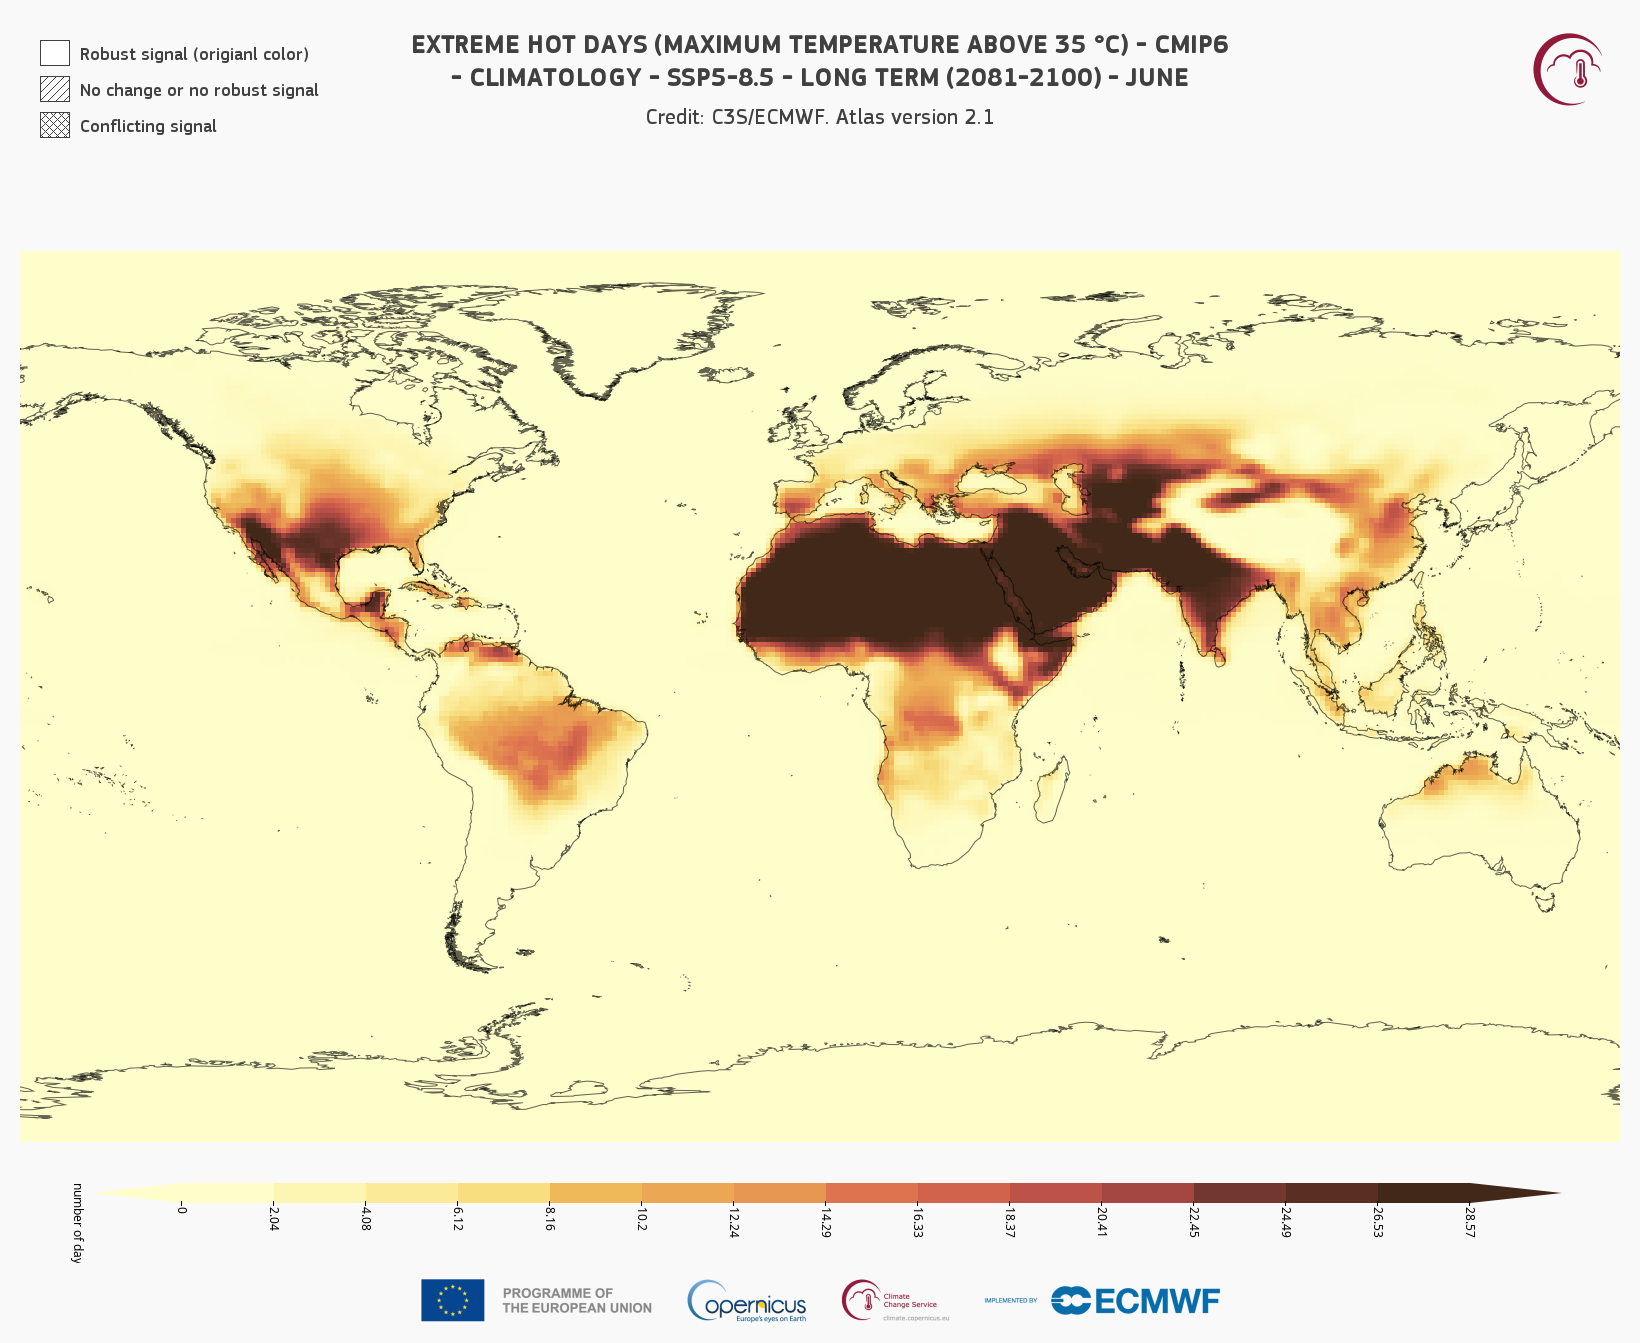

In [31]:
# Histogram
fig_hist = histogram_comparison_by_year(indicators_c3s_atlas, indicators_cmip6, indicator,
                                        glue_label="derived_multi-origin-c3s-atlas_consistency_q01_fig-hist-native")

```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q01_fig-hist-native
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q01_fig-hist-native"

Comparison between overall distributions of indicator (`tx35`) values in the C3S Atlas dataset and its reproduction,
across all spatial and temporal dimensions,
on the native grid of each dataset.
```

#### Reproducibility: Comparison on C3S Atlas grid

After regridding/interpolating,
the indicator values reproduced from the origin dataset
can be compared point-by-point to the values retrieved from the C3S Atlas dataset.
We first examine some metrics that describe the difference Δ between corresponding pixels:

In [32]:
display_difference_stats(indicators_c3s_atlas, indicators_cmip6_interpolated, indicator)

,Mean Δ,Median Δ,Median |Δ|,% where |Δ| ≥ ε,Median |Δ| [%],Pearson r
2060,-0.00077,0.00000,0.00000,0.07665,0.00000,0.99998
2080,-0.00095,0.00000,0.00000,0.09388,0.00000,0.99998


It is clear that the two datasets are extremely close:
the median difference and median absolute difference are both 0
and
fewer than 0.1% of pixel pairs show a non-zero difference
(defined here as |Δ| ≥ ε with ε = 10{sup}`–5` to avoid floating-point errors).
We can immediately conclude that the C3S Atlas dataset is highly reproducible
from its origins
using the provided workflow.


This conclusion is strengthened by examining the distributions of indicator values and their point-by-point differences
(Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q01_fig-hist-c3s-atlas>`).
The vast majority of pixel pairs have a difference of 0,
with very few ±1 and even fewer ±2
(note the logarithmic y-axis).

However, this raises an obvious question:
why are there any differences at all?
The geospatial distribution of differences
(Figure {numref}`{number} <derived_multi-origin-c3s-atlas_consistency_q01_fig-geocomp-regional>`)
does not appear to correlate with any patterns in the indicator values themselves nor in geography.
Since the differences are very small and seemingly random,
a potential explanation is that they simply result from small changes in
the origin dataset
and/or
the C3S Atlas workflow software
between the production of the C3S Atlas dataset and the present day.
Testing this hypothesis would require an extremely detailed analysis of all steps in the workflow,
which is outside the scope of this assessment.

Setting this question affecting <0.1% of pixels aside,
we can confidently conclude
from the metrics and figures
that the C3S Atlas dataset is highly reproducible from its origins using the provided workflow,
at least for the `tx35` indicator and CMIP6 dataset.

In [33]:
# Histogram
fig_hist = histogram_comparison_by_year_with_difference(indicators_c3s_atlas, indicators_cmip6_interpolated, indicator,
                                                        glue_label="derived_multi-origin-c3s-atlas_consistency_q01_fig-hist-c3s-atlas")

```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q01_fig-hist-c3s-atlas
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q01_fig-hist-c3s-atlas"

Comparison between overall distributions of indicator (`tx35`) values in the C3S Atlas dataset and its reproduction
on the C3S Atlas grid,
across all spatial and temporal dimensions,
including the per-pixel difference.
```

In [34]:
# Create plot with function defined at the start
geospatial_comparison_with_difference(indicators_c3s_atlas, indicators_cmip6_interpolated, indicator, month, domain=domain,
                                      glue_label="derived_multi-origin-c3s-atlas_consistency_q01_fig-geocomp-regional")

```{glue:figure} derived_multi-origin-c3s-atlas_consistency_q01_fig-geocomp-regional
:figwidth: 700px
:name: "derived_multi-origin-c3s-atlas_consistency_q01_fig-geocomp-regional"

Comparison between C3S Atlas dataset and reproduction for one indicator (`tx35`) in one month,
across Europe,
on the C3S Atlas dataset grid,
including the per-pixel difference.
```

## ℹ️ If you want to know more

### Key resources
The CDS catalogue entries for the data used were:
* Gridded dataset underpinning the Copernicus Interactive Climate Atlas: [multi-origin-c3s-atlas](https://doi.org/10.24381/cds.h35hb680)
  * **Consistency between the C3S Atlas dataset and its origins: Case study**
  * [](./derived_multi-origin-c3s-atlas_consistency_q02)
  * [](./derived_multi-origin-c3s-atlas_consistency_q03)
* CMIP6 climate projections: [projections-cmip6](https://doi.org/10.24381/cds.c866074c)
  * [Quality assessments for CMIP6](../Climate_Projections/CMIP6/CMIP6.md)


Code libraries used:
* [earthkit](https://github.com/ecmwf/earthkit)
  * [earthkit-data](https://github.com/ecmwf/earthkit-data)
  * [earthkit-plots](https://github.com/ecmwf/earthkit-plots)
* [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas)
* [xclim](https://xclim.readthedocs.io/en/stable/) climate indicator tools


More about the Copernicus Interactive Climate Atlas and its IPCC predecessor:
* [Copernicus Interactive Climate Atlas application](https://atlas.climate.copernicus.eu/)
* [Gridded data underpinning the Copernicus Interactive Climate Atlas: Description of the datasets and variables](https://confluence.ecmwf.int/display/CKB/Gridded+data+underpinning+the+Copernicus+Interactive+Climate+Atlas%3A+Description+of+the+datasets+and+variables)
* [The Copernicus Interactive Climate Atlas: a tool to explore regional climate change](https://doi.org/10.21957/ah52ufc369)
* [Copernicus Interactive Climate Atlas: a new tool to visualise climate variability and change](https://www.ecmwf.int/en/newsletter/179/news/copernicus-interactive-climate-atlas-new-tool-visualise-climate-variability)
* [Implementation of FAIR principles in the IPCC: the WGI AR6 Atlas repository](https://doi.org/10.1038/s41597-022-01739-y)
* [Climate Change 2021 – The Physical Science Basis: Atlas](https://doi.org/10.1017/9781009157896.021)

### References
[[Gutiérrez+24](https://doi.org/10.21957/ah52ufc369)] J. M. Gutiérrez et al., ‘The Copernicus Interactive Climate Atlas: a tool to explore regional climate change’, ECMWF Newsletter, vol. 181, pp. 38–45, Oct. 2024, doi: 10.21957/ah52ufc369.

[[C3S Atlas dataset](https://doi.org/10.24381/cds.h35hb680)] Copernicus Climate Change Service, ‘Gridded dataset underpinning the Copernicus Interactive Climate Atlas’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Jun. 17, 2024. doi: 10.24381/cds.h35hb680.

[[CMIP6 dataset](https://doi.org/10.24381/cds.c866074c)] Copernicus Climate Change Service, ‘CMIP6 climate projections’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Mar. 23, 2021. doi: 10.24381/cds.c866074c.

[[Burggraaff+20](https://doi.org/10.1364/OE.391470)] O. Burggraaff, ‘Biases from incorrect reflectance convolution’, Optics Express, vol. 28, no. 9, pp. 13801–13816, Apr. 2020, doi: 10.1364/OE.391470.